# Time-series models

In [17]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# suppress warning
import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy

# Homework 1: Using ARIMA model to predict food_retail capital in Australia.

In [7]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/australian_capital_retail.csv')

## Task 1. Sum up the yearly capital of food retailing and visualize the timeline.

In [8]:
df['year'] = pd.to_datetime(df['month']).dt.year
df = df.groupby('year').sum()

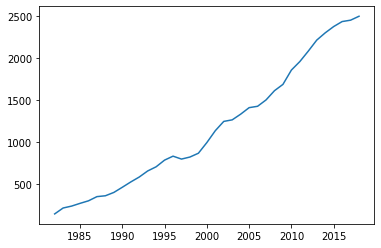

In [9]:
category = 'food_retailing'
plt.plot(df[category])

## Task 2. Usr the adfuller tool to determine if the time series is stationary or not, $\alpha=0.05$. If not, find a proper order of differencing (d) in the ARIMA model to reach the stationarity, and report adfuller test results after differencing.

In [10]:
series=df[category]
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 2.548309
p-value: 0.999064
Critical Values:
	1%: -3.679
	5%: -2.968
	10%: -2.623


In [11]:
#reaches the stationarity after first differencing
result = adfuller(series.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -3.444382
p-value: 0.009536


## Task 3. Analyze the PACF and ACF plots to determine appropriate number of AR, MA terms

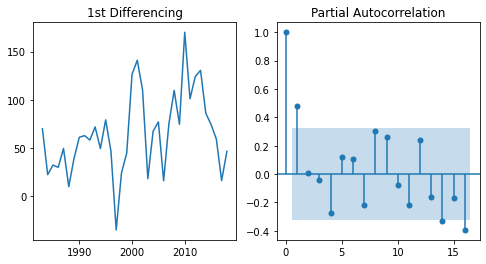

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].plot(series.diff())
axes[0].set_title('1st Differencing')

plot_pacf(series.diff().dropna(), ax=axes[1])

plt.show()

One AR term suggested (drop-off into the non-signifinace zone after)

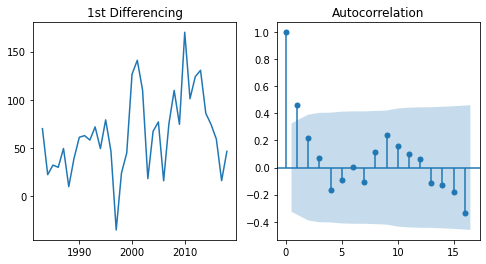

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].plot(series.diff()); axes[0].set_title('1st Differencing')
plot_acf(series.diff().dropna(), ax=axes[1],alpha=0.05)

plt.show()

Zero or one MA suggested - first lag is the only one beyond the non-significance zone and even this first one not that much higher than it

## Task 4, build up an ARIMA(1,1,1) model, train on the first 30 data points, test on the last 7. Check the autocorrelation and normal distribution hypothesis for residuals from training data.

                             ARIMA Model Results                              
Dep. Variable:       D.food_retailing   No. Observations:                   29
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -147.113
Method:                       css-mle   S.D. of innovations             38.506
Date:                Sun, 07 Feb 2021   AIC                            302.226
Time:                        16:12:40   BIC                            307.695
Sample:                             1   HQIC                           303.938
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     62.8625     10.767      5.838      0.000      41.759      83.966
ar.L1.D.food_retailing     0.1793      0.672      0.267      0.790      -1.138       1.497
ma.L

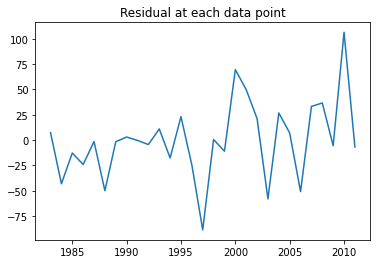

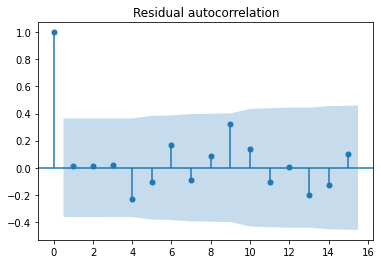

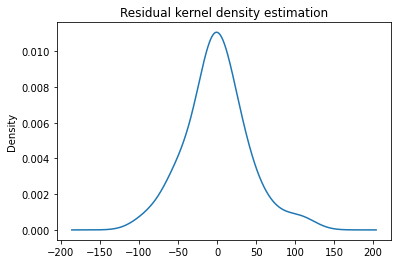

                0
count   29.000000
mean    -0.180922
std     39.198809
min    -88.601055
25%    -17.591988
50%     -1.414517
75%     21.172380
max    106.362966
p value is  0.22330957386549957
null hypothesis: residuals comes from a normal distribution
The null hypothesis cannot be rejected


In [18]:
P=1
D=1
Q=1

# fit model
N=30   
model = ARIMA(series[:N], order=(Q,D,P))
model_fit = model.fit(disp = 0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
# plt.figure(figsize = (6,4))
plt.plot(residuals)
plt.title('Residual at each data point')
plot_acf(residuals)
plt.title('Residual autocorrelation')
plt.show()
residuals.plot(kind='kde', legend=False)
plt.title('Residual kernel density estimation')
plt.show()
print(residuals.describe())
k2, p = scipy.stats.normaltest(residuals)
alpha = 0.1
print('p value is ',p[0])

print('null hypothesis: residuals comes from a normal distribution')
if p < alpha:  
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

In [20]:
model_fit.aic

302.22555984087654

In [32]:
### a function for grading
def outputResults(adfuller_p_value, fitted_arima_model, residual_normaltest_p_value):
    import csv
    '''
    please pass your argument in this function
    adfuller_p_value: the p value of the stationary series from adfuller test;
    fitted_arima_model: your fitted ARIMA model;
    residual_normaltest_p_value: the normal test's p value of residual from ARIMA model
    '''
    if type(adfuller_p_value) == np.ndarray:
        adfuller_p_value = adfuller_p_value[0]
    if type(residual_normaltest_p_value) == np.ndarray:
        residual_normaltest_p_value = residual_normaltest_p_value[0]
    with open('output.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(['adfuller','AIC','normaltest'])
        writer.writerow([adfuller_p_value, fitted_arima_model.aic, residual_normaltest_p_value])

In [33]:
outputResults()

/Users/stanislav/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/stanislav/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


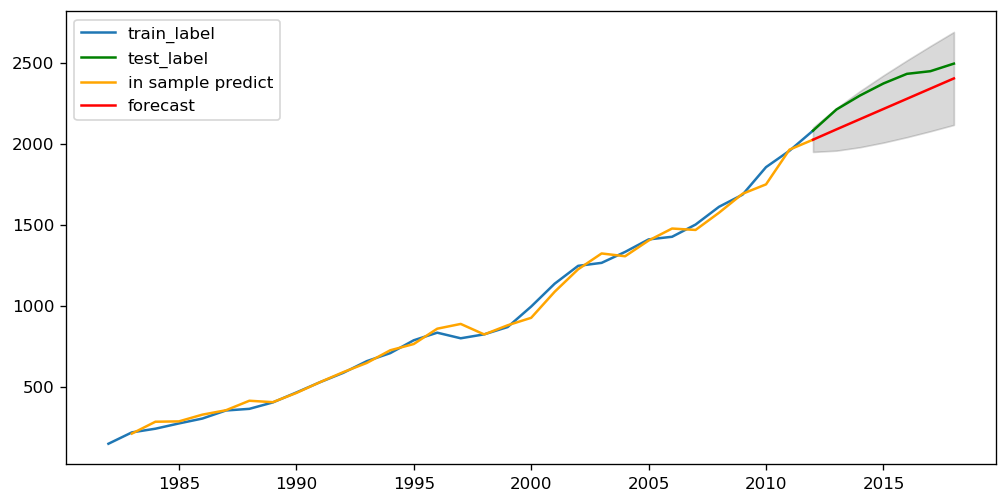

In [57]:
forecast = model_fit.forecast(steps=len(series)-N, alpha=0.05)[0]  # 95% conf
# Forecast
fc, se, conf = model_fit.forecast(steps=len(series)-N, alpha=0.05)  # 95% conf

fc_series = pd.Series(fc, index=range(N,len(series)))
lower_series = pd.Series(conf[:, 0], index=range(N,len(series)))
upper_series = pd.Series(conf[:, 1], index=range(N,len(series)))

plt.rcParams.update({'figure.figsize':(10,5)})
# plt.plot(series)

# plt.plot(series)
plt.plot(df.index[:N+1],series[:N+1],label='train_label')
plt.plot(df.index[N:],series[N:],color='green',label='test_label')
plt.plot(df.iloc[1:N+1].index,model_fit.predict(start=1,end=N,dynamic=False,typ='levels'),color='orange',label='in sample predict')
plt.plot(df.iloc[N:].index,fc_series.tolist(), label='forecast', color='red')
plt.fill_between(df.iloc[N:].index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.legend(loc='upper left')



# Homework 2: Using ARIMA model to predict a one-direction random walk.
### Task 1, generate a one-dimensional random walk which starts at 0 and makes a step up or down with the equal probability. Simulate 1000 steps and use the random seed 1234. Visualize the result.

In [58]:
np.random.seed(1234)
nsteps = 1000

pos1 = 0 
walk1 = [pos1]
for i in range(nsteps):
    step1 = 1 if np.random.randint(0, 2) else -1 
    pos1 += step1
    walk1.append(pos1)

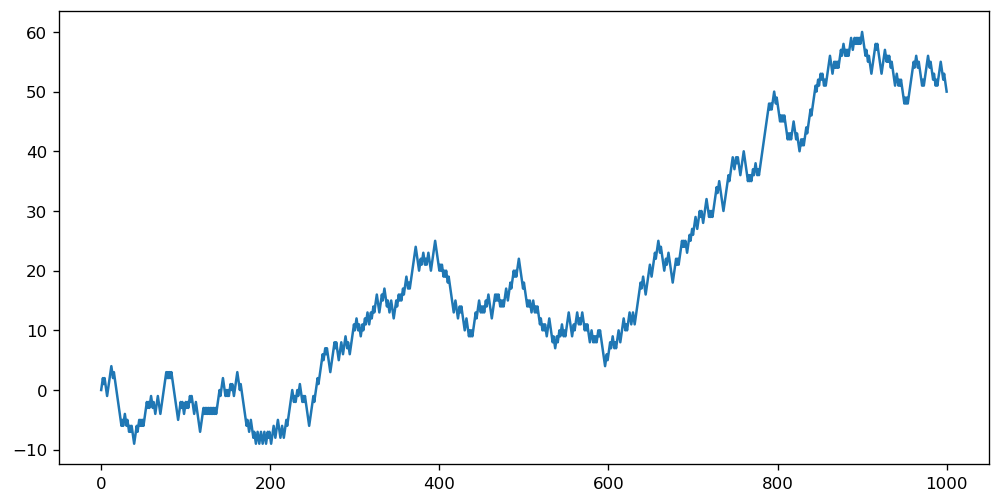

In [59]:
plt.plot(walk1)

### Task 2, difference the series to stationary, and report the adfuller test results, $\alpha=0.05$

In [60]:
walk = pd.Series(walk1)
result = adfuller(walk.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -31.746941
p-value: 0.000000


### Task 3, PACF and ACF plot of the diferenced time-series.

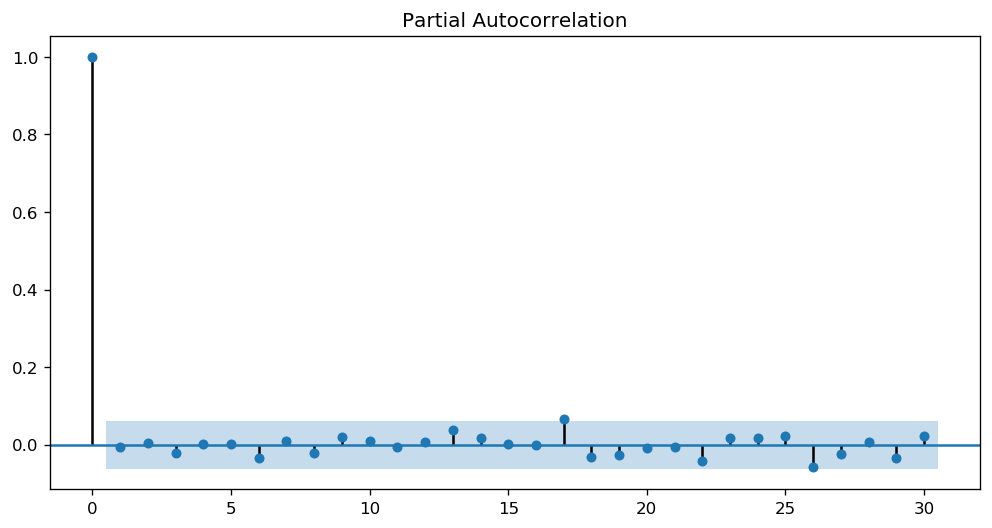

In [61]:
fig = plot_pacf(walk.diff().dropna())

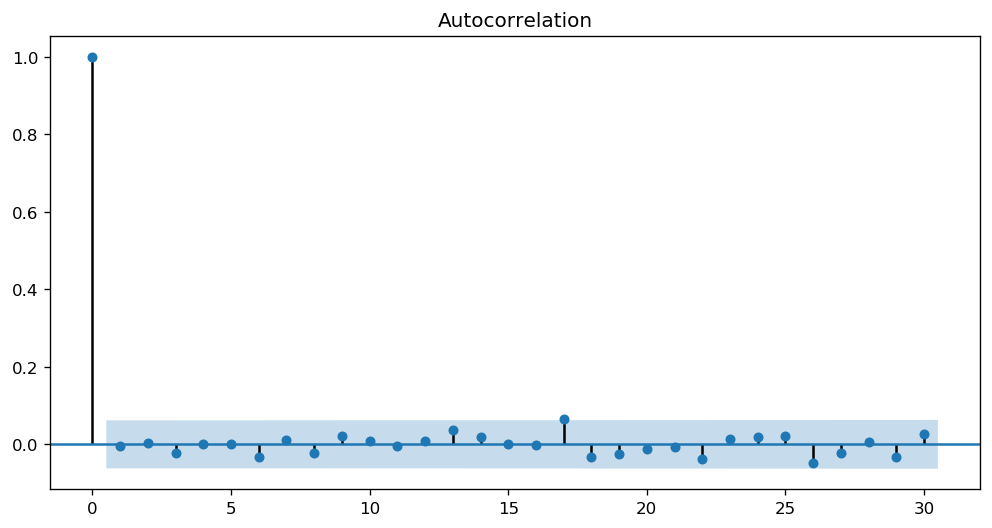

In [62]:
fig = plot_acf(walk.diff().dropna())

### Task 4, When analyzing the PACF and ACF results of the random walk, what pattern shows that ARIMA won't be a useful model for this time-series? Write down your statement.

In the PACF and ACF plots, we can hardly find any significant correlations (values outside of the blue area) over any lag values. As its name indicates, this situation makes sense, a random walk is random. Even though the current position is based on the previous position, a single differencing removes this relationship. So after differencing, ARIMA (or actually ARMA) will be challenged to modeling the differences between consequitive steps, which are randomly generated and according to the ACF/PACF plots do not show any significant autocorrelations. ARIMA can not help modeling a dataset if autocorrelation does not exist in it.